In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np


import os
import json
import pyarrow.parquet as pq
import pyarrow as pa
from datasets import Dataset, DatasetDict, concatenate_datasets
from datasets import Features, Value
from datasets import  load_dataset, DownloadConfig
from datasets import load_from_disk
import pandas as pd



from utils.data_loaders import BiBci2000MELR_filter, BiBci2000MELR
from models.bi_lstm import BiLSTMEncoder, ToyClassifier
from huggingface_hub import hf_hub_download
from huggingface_hub import snapshot_download
from PyEMD import CEEMDAN, EMD

In [2]:
# 超参数
BATCH_SIZE = 96
EPOCHS = 200
LEARNING_RATE = 0.0001
HIDDEN_SIZE = 50
NUM_LAYERS = 2
NUM_CLASSES = 1  # 二分类任务
INPUT_SIZE = 656  
SEQ_LENGTH = 64  


In [3]:
print(torch.cuda.is_available())  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [4]:
train_path = "D:\\EEG25_Data\\BCI2000_cls9\\sliced\\train"
test_path = "D:\\EEG25_Data\\BCI2000_cls9\\sliced\\test"

# 列出文件夹中的所有文件
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

# 筛选出所有的PT文件
train_files = [f for f in train_files if f.endswith('.pt')]
test_files = [f for f in test_files if f.endswith('.pt')]

# 初始化存储列表
train_data_list = []
train_label_list = []
test_data_list = []
test_label_list = []

# 处理测试集
index = 0
for pt_file in test_files:
    file_path = os.path.join(test_path, pt_file)
    try:
        data = torch.load(file_path)
        
        # 检查第二个维度长度
        if data.shape[1] < 640:
            print(f"跳过测试文件 {pt_file}，第二维度长度 {data.shape[1]} < 640")
            continue
            
        # 处理标签
        label = pt_file.split("_")[-1]
        label = label[3]  # 假设文件名格式为 XXX_clsX.pt
        test_label_list.append(int(label))  # 转换为整数
        
        # 处理数据
        data = data[:, :640]
        test_data_list.append(data)
        
    except Exception as e:
        print(f"加载测试文件 {pt_file} 失败: {str(e)}")
    
    index += 1
    print(f"测试集处理进度: {index/len(test_files):.2%}")

# 处理训练集
index = 0
for pt_file in train_files:
    file_path = os.path.join(train_path, pt_file)
    try:
        data = torch.load(file_path)
        
        # 检查第二个维度长度
        if data.shape[1] < 640:
            print(f"跳过训练文件 {pt_file}，第二维度长度 {data.shape[1]} < 640")
            continue
            
        # 处理标签
        label = pt_file.split("_")[-1]
        label = label[3]  # 假设文件名格式为 XXX_clsX.pt
        train_label_list.append(int(label))  # 转换为整数
        
        # 处理数据
        data = data[:, :640]
        train_data_list.append(data)
        
    except Exception as e:
        print(f"加载训练文件 {pt_file} 失败: {str(e)}")
    
    index += 1
    print(f"训练集处理进度: {index/len(train_files):.2%}")

# 最终统计信息
print("\n处理结果统计:")
print(f"有效测试样本数: {len(test_data_list)}/{len(test_files)}")
print(f"有效训练样本数: {len(train_data_list)}/{len(train_files)}")

C:\Users\ChenYiqiao\AppData\Local\Temp\ipykernel_18008\132860326.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


测试集处理进度: 0.01%
测试集处理进度: 0.02%
测试集处理进度: 0.03%
测试集处理进度: 0.03%
测试集处理进度: 0.04%
测试集处理进度: 0.05%
测试集处理进度: 0.06%
测试集处理进度: 0.07%
测试集处理进度: 0.08%
测试集处理进度: 0.09%
测试集处理进度: 0.09%
测试集处理进度: 0.10%
测试集处理进度: 0.11%
测试集处理进度: 0.12%
测试集处理进度: 0.13%
测试集处理进度: 0.14%
测试集处理进度: 0.14%
测试集处理进度: 0.15%
测试集处理进度: 0.16%
测试集处理进度: 0.17%
测试集处理进度: 0.18%
测试集处理进度: 0.19%
测试集处理进度: 0.20%
测试集处理进度: 0.20%
测试集处理进度: 0.21%
测试集处理进度: 0.22%
测试集处理进度: 0.23%
测试集处理进度: 0.24%
测试集处理进度: 0.25%
测试集处理进度: 0.26%
测试集处理进度: 0.26%
测试集处理进度: 0.27%
测试集处理进度: 0.28%
测试集处理进度: 0.29%
测试集处理进度: 0.30%
测试集处理进度: 0.31%
测试集处理进度: 0.32%
测试集处理进度: 0.32%
测试集处理进度: 0.33%
测试集处理进度: 0.34%
测试集处理进度: 0.35%
测试集处理进度: 0.36%
测试集处理进度: 0.37%
测试集处理进度: 0.37%
测试集处理进度: 0.38%
测试集处理进度: 0.39%
测试集处理进度: 0.40%
测试集处理进度: 0.41%
测试集处理进度: 0.42%
测试集处理进度: 0.43%
测试集处理进度: 0.43%
测试集处理进度: 0.44%
测试集处理进度: 0.45%
测试集处理进度: 0.46%
测试集处理进度: 0.47%
测试集处理进度: 0.48%
测试集处理进度: 0.49%
测试集处理进度: 0.49%
测试集处理进度: 0.50%
测试集处理进度: 0.51%
测试集处理进度: 0.52%
测试集处理进度: 0.53%
测试集处理进度: 0.54%
测试集处理进度: 0.55%
测试集处理进度: 0.55%
测试集处理进度: 0.56%
测试集处理进度: 0

C:\Users\ChenYiqiao\AppData\Local\Temp\ipykernel_18008\132860326.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


训练集处理进度: 0.06%
训练集处理进度: 0.06%
训练集处理进度: 0.07%
训练集处理进度: 0.07%
训练集处理进度: 0.07%
训练集处理进度: 0.08%
训练集处理进度: 0.08%
训练集处理进度: 0.08%
训练集处理进度: 0.09%
训练集处理进度: 0.09%
训练集处理进度: 0.09%
训练集处理进度: 0.10%
训练集处理进度: 0.10%
训练集处理进度: 0.11%
训练集处理进度: 0.11%
训练集处理进度: 0.11%
训练集处理进度: 0.12%
训练集处理进度: 0.12%
训练集处理进度: 0.12%
训练集处理进度: 0.13%
训练集处理进度: 0.13%
训练集处理进度: 0.14%
训练集处理进度: 0.14%
训练集处理进度: 0.14%
训练集处理进度: 0.15%
训练集处理进度: 0.15%
训练集处理进度: 0.15%
训练集处理进度: 0.16%
训练集处理进度: 0.16%
训练集处理进度: 0.16%
训练集处理进度: 0.17%
训练集处理进度: 0.17%
训练集处理进度: 0.18%
训练集处理进度: 0.18%
训练集处理进度: 0.18%
训练集处理进度: 0.19%
训练集处理进度: 0.19%
训练集处理进度: 0.19%
训练集处理进度: 0.20%
训练集处理进度: 0.20%
训练集处理进度: 0.20%
训练集处理进度: 0.21%
训练集处理进度: 0.21%
训练集处理进度: 0.22%
训练集处理进度: 0.22%
训练集处理进度: 0.22%
训练集处理进度: 0.23%
训练集处理进度: 0.23%
训练集处理进度: 0.23%
训练集处理进度: 0.24%
训练集处理进度: 0.24%
训练集处理进度: 0.24%
训练集处理进度: 0.25%
训练集处理进度: 0.25%
训练集处理进度: 0.26%
训练集处理进度: 0.26%
训练集处理进度: 0.26%
训练集处理进度: 0.27%
训练集处理进度: 0.27%
训练集处理进度: 0.27%
训练集处理进度: 0.28%
训练集处理进度: 0.28%
训练集处理进度: 0.28%
训练集处理进度: 0.29%
训练集处理进度: 0.29%
训练集处理进度: 0.30%
训练集处理进度: 0

In [5]:
print(type(train_data_list))
print(len(test_data_list))
print(test_data_list[0].shape)

<class 'list'>
11625
torch.Size([64, 640])


In [6]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels

    def __getitem__(self, index):
        eeg = self.datas[index]
        label = self.labels[index]

        return eeg, torch.tensor(label, dtype=torch.long)
    
    def __len__(self):
        return len(self.datas)
        
train_set = dataset(train_data_list, train_label_list)
test_set = dataset(test_data_list, test_label_list)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [9]:
# 初始化模型
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv1d, self).__init__()
        # 深度wise卷积
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        # point wise卷积
        self.pointwise = nn.Conv1d(in_channels, out_channels, 1, stride=1, padding=0)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class FFCL(nn.Module):
    def __init__(self):
        super(FFCL, self).__init__()
        #CNN
        self.conv1D = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(64, 80), stride=1, padding=(0, 40))
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.avg_pool1 = nn.AvgPool1d(kernel_size=4, stride=1)
        self.dropout1 = nn.Dropout(p=0.5)
        self.flatten1 = nn.Flatten()
        self.separable_conv1D = DepthwiseSeparableConv1d(in_channels=16, out_channels=24, kernel_size=16, stride=1, padding=8)
        self.bn2 = nn.BatchNorm1d(num_features=24)
        self.avg_pool2 = nn.AvgPool1d(kernel_size=8, stride=1)
        self.dropout2 = nn.Dropout(p=0.5)
        self.flatten2 = nn.Flatten()

        #LSTM
        self.lstm = nn.LSTM(input_size=64, hidden_size=50, num_layers=1, batch_first=True)
        self.dropout3 = nn.Dropout(p=0.5)
        self.flatten3 = nn.Flatten()

    def forward(self, x):
        #CNN
        y = x.clone()      
        y = y[:, None, :]
        y = self.conv1D(y).squeeze(2) #output: torch.Size([batchsize, 16, 657])
        y = self.bn1(y) #output: torch.Size([batchsize, 16, 657])
        y = self.avg_pool1(y) #output: torch.Size([batchsize, 16, 654])
        y = self.dropout1(y) #output: torch.Size([batchsize, 16, 654])
        feature1 = self.flatten1(y) #output: torch.Size([batchsize, 10464])第一个展平层得到的输出，中间层特征
        y = self.separable_conv1D(y) #output: torch.Size([batchsize, 24, 655])
        y = self.bn2(y) #output: torch.Size([batchsize, 24, 655])
        y = self.avg_pool2(y) #output: torch.Size([batchsize, 24, 648])
        y = self.dropout2(y) #output: torch.Size([batchsize, 24, 648])
        feature2 = self.flatten2(y) #output: torch.Size([batchsize, 15552])第二个展平层得到的输出，空间特征

        #LSTM
        # 初始化隐藏状态和细胞状态
        x = x.squeeze(1)
        x = torch.permute(x,(0,2,1))
        h0 = torch.zeros(1, x.size(0), 50).to(device)
        c0 = torch.zeros(1, x.size(0), 50).to(device)
        z, _ = self.lstm(x, (h0, c0))
        # 只取序列的最后一个时间步的输出
        z = z[:, -1, :] #output: torch.Size([batchsize, 50])
        z = self.dropout3(z) #output: torch.Size([batchsize, 50])
        feature3 = self.flatten3(z) #output: torch.Size([batchsize, 50])第三个展平层输出，时域特征

        #最终特征
        feature = torch.cat((feature1, feature2, feature3), axis=1) #output: torch.Size([batchsize, 26066])全部特征
        
        return feature
    
class ClassificationHead(nn.Module):
    def __init__(self, 
                 input_dim=512, 
                 num_classes=8,
                 hidden_dims=[512, 256, 128],      # 隐藏层维度设置
                 dropout_prob=0.3,       # Dropout概率
                 use_batchnorm=False):   # 是否使用批归一化
        super().__init__()
        
        layers = []
        current_dim = input_dim
        
        # 动态构建隐藏层
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
                
            layers.append(nn.ReLU(inplace=True))
            
            if dropout_prob > 0:
                layers.append(nn.Dropout(p=dropout_prob))
            
            current_dim = h_dim
        
        # 最终分类层
        layers.append(nn.Linear(current_dim, num_classes))
        
        self.head = nn.Sequential(*layers)
        
        # 权重初始化
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.head(x)

ffcl = FFCL().to(device)
classifier = ClassificationHead(input_dim=25426, num_classes=9).to(device)

model = nn.Sequential(ffcl, classifier).to(device)

# 损失函数 & 优化器
criterion = nn.CrossEntropyLoss()  # 二分类交叉熵损失
optimizer = optim.Adam(list(model.parameters()), lr=LEARNING_RATE)


In [10]:
# 训练模型
for epoch in range(200):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()  # 清空梯度
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/200], Loss: 2.2649
Epoch [2/200], Loss: 1.8459
Epoch [3/200], Loss: 1.7275
Epoch [4/200], Loss: 1.6534
Epoch [5/200], Loss: 1.5983
Epoch [6/200], Loss: 1.5564
Epoch [7/200], Loss: 1.5205
Epoch [8/200], Loss: 1.4963
Epoch [9/200], Loss: 1.4734
Epoch [10/200], Loss: 1.4438
Epoch [11/200], Loss: 1.4181
Epoch [12/200], Loss: 1.4118
Epoch [13/200], Loss: 1.3861
Epoch [14/200], Loss: 1.3711
Epoch [15/200], Loss: 1.3540
Epoch [16/200], Loss: 1.3290
Epoch [17/200], Loss: 1.3190
Epoch [18/200], Loss: 1.2989
Epoch [19/200], Loss: 1.2803
Epoch [20/200], Loss: 1.2630
Epoch [21/200], Loss: 1.2513
Epoch [22/200], Loss: 1.2289
Epoch [23/200], Loss: 1.2172
Epoch [24/200], Loss: 1.1898
Epoch [25/200], Loss: 1.1856
Epoch [26/200], Loss: 1.1619
Epoch [27/200], Loss: 1.1431
Epoch [28/200], Loss: 1.1218
Epoch [29/200], Loss: 1.1177
Epoch [30/200], Loss: 1.0927
Epoch [31/200], Loss: 1.0683
Epoch [32/200], Loss: 1.0538
Epoch [33/200], Loss: 1.0407
Epoch [34/200], Loss: 1.0203
Epoch [35/200], Loss: 1

In [11]:
#保存模型
torch.save(model.state_dict(), "parameter\\experiment2")

In [12]:
import torch
from torch.utils.data import DataLoader
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# 存储真实标签和预测结果
all_labels = []
all_logits = []

# 假设dataset是PyTorch Dataset对象
dataloader = DataLoader(test_set, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        all_logits.append(outputs.cpu())
        all_labels.append(labels.cpu())

# 合并结果
y_true = torch.cat(all_labels).numpy()          # 形状 [n_samples]
logits = torch.cat(all_logits).numpy()          # 形状 [n_samples, 9]
y_pred = logits.argmax(axis=1)                  # 预测类别 [n_samples]
y_probs = torch.softmax(torch.tensor(logits), dim=1).numpy()  # 概率 [n_samples, 9]

In [13]:
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score, fbeta_score, cohen_kappa_score
from torchinfo import summary

# 计算各项指标
macro_acc = balanced_accuracy_score(y_true, y_pred)
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')
macro_f2 = fbeta_score(y_true, y_pred, beta=2, average='macro')
macro_kappa = cohen_kappa_score(y_true, y_pred)

# 打印指标结果
print("Evaluation Metrics:")
print(f"Macro Accuracy: {macro_acc:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Macro F2: {macro_f2:.4f}")
print(f"Cohen's Kappa: {macro_kappa:.4f}")

input_shape = (512, 64, 640)  

print("Model Summary:")
summary(model, input_size=input_shape, device=device.type)

Evaluation Metrics:
Macro Accuracy: 0.3011
Macro Recall: 0.3011
Macro Precision: 0.3398
Macro F1: 0.3145
Macro F2: 0.3054
Cohen's Kappa: 0.3343
Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [512, 9]                  --
├─FFCL: 1-1                              [512, 25426]              --
│    └─Conv2d: 2-1                       [512, 16, 1, 641]         81,936
│    └─BatchNorm1d: 2-2                  [512, 16, 641]            32
│    └─AvgPool1d: 2-3                    [512, 16, 638]            --
│    └─Dropout: 2-4                      [512, 16, 638]            --
│    └─Flatten: 2-5                      [512, 10208]              --
│    └─DepthwiseSeparableConv1d: 2-6     [512, 24, 639]            --
│    │    └─Conv1d: 3-1                  [512, 16, 639]            272
│    │    └─Conv1d: 3-2                  [512, 24, 639]            408
│    └─BatchNorm1d: 2-7                  [512, 24, 639]            48
│    └─AvgPool1d: 2-8                    [512, 24, 632]            --
│    └─Dropout: 2-9                      [512, 24, 632]            --
│    └─Fl

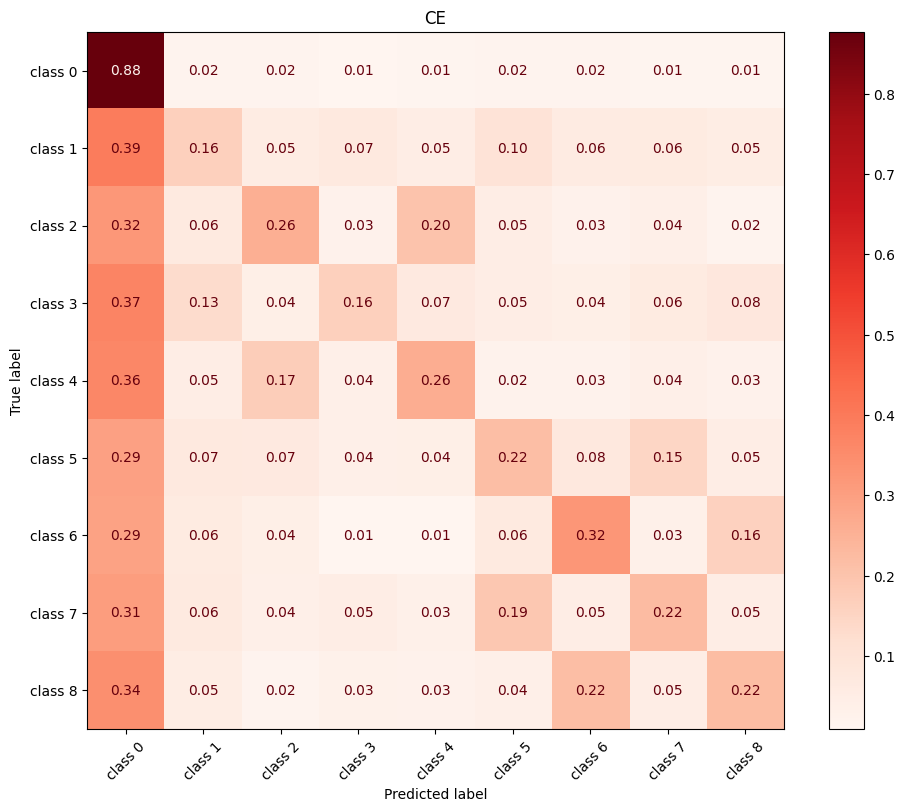

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score


# 混淆矩阵
cm = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[f"class {i}" for i in range(9)]
)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Reds', values_format='.2f')
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("CE")
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [19]:
# 计算每个类别的ROC AUC（One-vs-Rest）
from sklearn.preprocessing import label_binarize

# 将标签转换为二值形式
y_true_bin = label_binarize(y_true, classes=range(9))

# 计算每个类别的AUC
for i in range(8):
    auc = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
    print(f"类{i}的ROC AUC: {auc:.4f}")

类0的ROC AUC: 0.8625
类1的ROC AUC: 0.7285
类2的ROC AUC: 0.7795
类3的ROC AUC: 0.7489
类4的ROC AUC: 0.7773
类5的ROC AUC: 0.7776
类6的ROC AUC: 0.8046
类7的ROC AUC: 0.7842


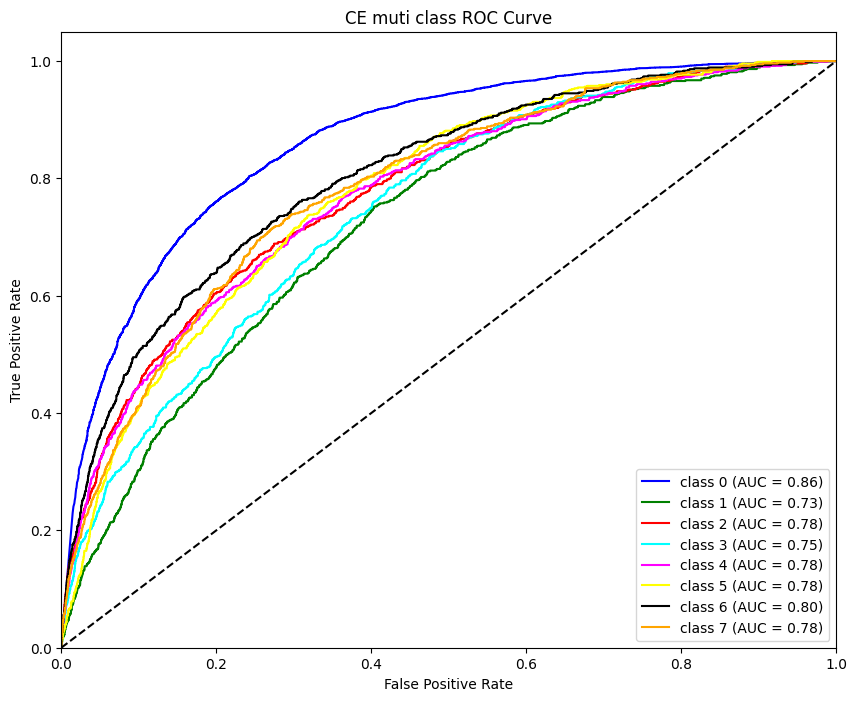

In [20]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

# 为每个类别绘制ROC曲线
for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
             label=f'class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CE muti class ROC Curve')
plt.legend(loc="lower right")
plt.show()